In [1]:
%config IPCompleter.use_jedi = False

In [2]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2

In [3]:
from matplotlib import pyplot as plt
import numpy as np

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [4]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  11_groups.csv  groups.csv
10_groups.csv  bad_ids.csv    product_groups.csv


# I created one file with all groups

In [5]:
df = pd.read_csv('./data/groups.csv')

In [6]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [7]:
bad_ids = pd.read_csv('./data/bad_ids.csv', names=['index', 'id_card'], index_col=0, skiprows=1)
bad_ids

,id_card
index,
0,806096
1,1438102
2,72344
3,427981
4,1528414
...,...
24702,1936560
24703,1937859
24704,1938164


In [8]:
# Drop bad id cards records
df = df[~df['id_card'].isin(bad_ids['id_card'])]

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

Lets formulate problem in following way:
$H_0$ - there is no dependence of probability of discount on sum of order.  
In other words for any $\Delta > 0$,   $P(x)$ = $P(x+\Delta)$, where P(x) - probability of having a discount with sum equals to x.  
Or in other words $H_0$ is that $P(x) \sim U(start, end)$ 

In [8]:
discount_sum_stat = df.groupby('id_doc').agg({'is_green': 'sum', 'sum': 'sum'})

In [23]:
# Lets find upper bound for price to drop outliers take 0.999 quantile
max_price = np.quantile(discount_sum_stat['sum'].values, 0.999)

In [37]:
start, stop, step = 0, max_price, 100
# Take sums from boughts wich has discounts
sums_disc = discount_sum_stat[discount_sum_stat['is_green']!=0]['sum'].values
# Take sums from boughts wich does not have any discounts
sums_non_disc = discount_sum_stat[discount_sum_stat['is_green']==0]['sum'].values
# Create hist with discounts and non discounts
i_disc, bins = np.histogram(sums_disc, np.arange(start, stop, step))
i_non_disc, bins = np.histogram(sums_non_disc, bins)
# Count proba for discount on sum
p_disc = i_disc / (i_disc+i_non_disc)
p_disc = np.nan_to_num(p_disc, nan=0.0)
p_disc = p_disc / np.sum(p_disc)

<BarContainer object of 62 artists>

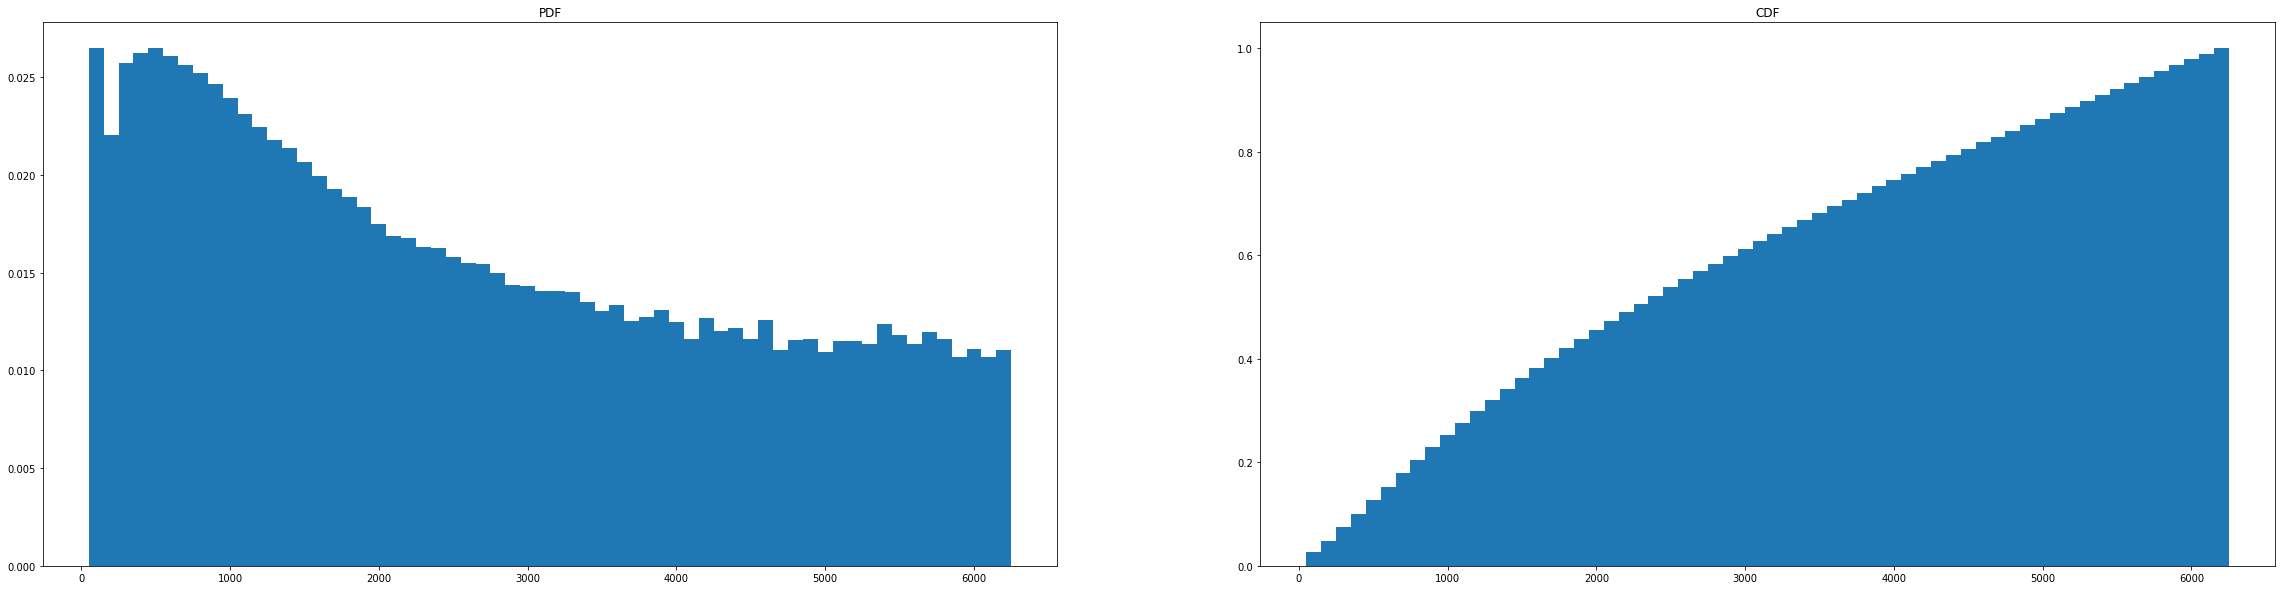

In [38]:
# Lets look at this PDF and CDF
figure = plt.figure(figsize=(40,10))
figure.add_subplot(1, 2, 1)
plt.title('PDF')
plt.bar(bins[1:], p_disc, width=step)
figure.add_subplot(1, 2, 2)
plt.title('CDF')
plt.bar(bins[1:], np.cumsum(p_disc), width=step)

They look not like uniform distribution, but lets check with Kolmogorov-Smirnov test 

In [98]:
from scipy import stats

# Generate items from 0 to 1 from our distribution
to_check = np.random.choice(np.linspace(0,1,len(p_disc)), 100000, p=p_disc)
# Apply test
stats.kstest(to_check, stats.uniform.cdf)

KstestResult(statistic=0.14722081967213113, pvalue=0.0)

We reject $H_0$ meaning that  $P(x)$ !$\sim U(start, end)$

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [8]:
# Get only unique orders
df = df.groupby('id_doc', as_index=False).first()

In [26]:
# Convert to day. I use this aproach as it faster
df.iloc[:,1] = df.iloc[:,1].apply(lambda x: int(str(x)[8:10]))

In [35]:
date_counts = df.groupby('date').count()['id_doc']
# Drop 31day as it is not in all months
date_counts = date_counts[:-1]

<BarContainer object of 30 artists>

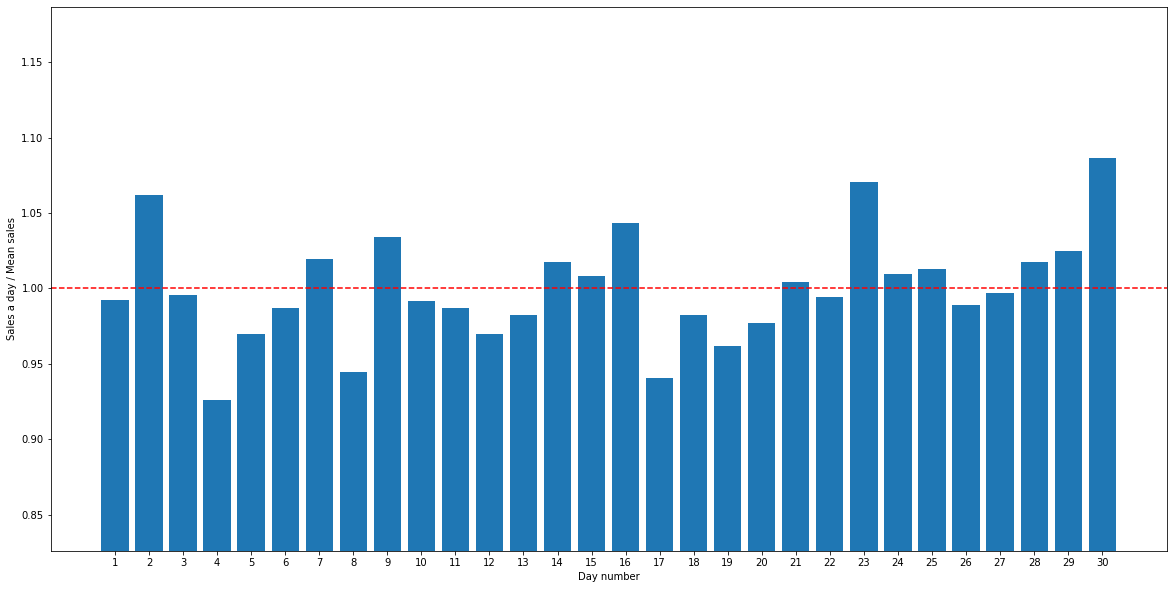

In [62]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
dates = date_counts.index
mean = date_counts.values.mean()
lift = date_counts.values / mean
ax.set(ylim=[lift.min()-0.1, lift.max()+0.1])
ax.set_xticks(dates)
ax.set_xlabel('Day number')
ax.set_ylabel('Sales a day / Mean sales')
ax.axhline(1.0, color='r', linestyle='--')
plt.bar(dates, lift)

### Here we can see growth 4-7 days, from 12-16 days, from 17-23 days, from 26-30 days

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

# Purchases a month

In [7]:
# Get only unique orders
df = df.groupby('id_doc', as_index=False).first()
df['date'] = pd.to_datetime(df['date']).dt.day
df_agg = df.groupby(['id_card', 'date'], as_index=False).first().groupby('id_card', as_index=False).count().groupby('date').count()

<BarContainer object of 30 artists>

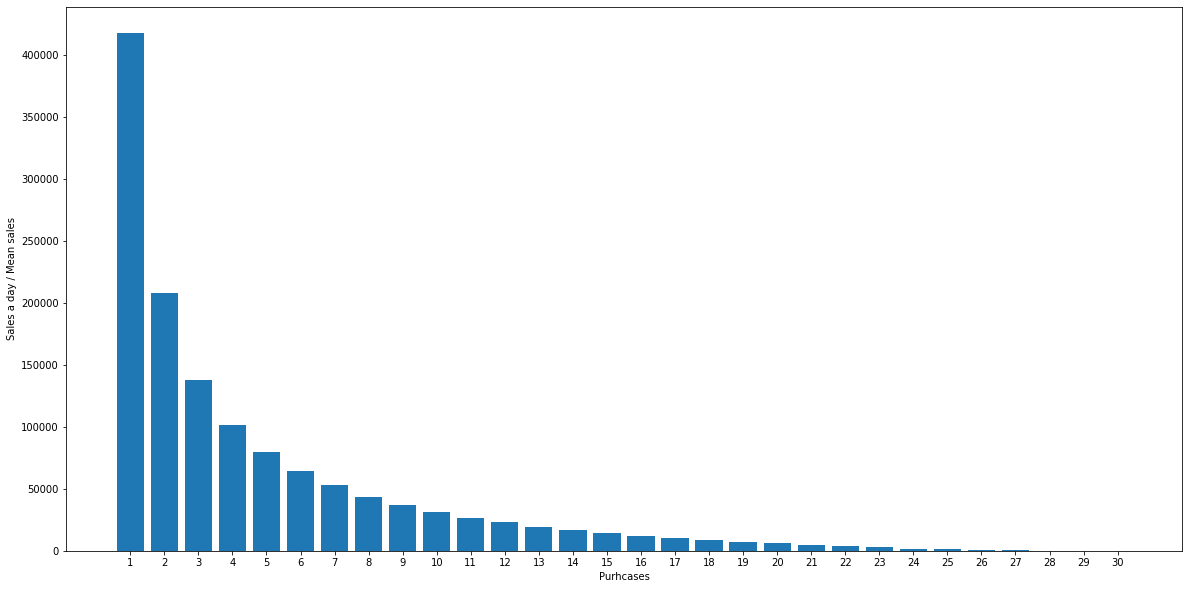

In [28]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
freqs = df_agg.index
amount = df_agg['sum']
ax.set_xticks(freqs)
ax.set_xlabel('Purhcases')
ax.set_ylabel('')
plt.bar(freqs, amount)

# Mean purchases

In [10]:
# Get only unique orders
df_agg = df.groupby(['id_card', 'id_doc'], as_index=False).agg({'sum':'sum'}).groupby('id_card').agg({'sum':'mean'})

In [13]:
values = df_agg['sum'].values

In [19]:
max_price = np.quantile(values, 0.99)
start, stop, step = 0, max_price, 100
# Take sums from boughts wich has discounts
height, bins = np.histogram(values, np.arange(start, stop, step))

<BarContainer object of 30 artists>

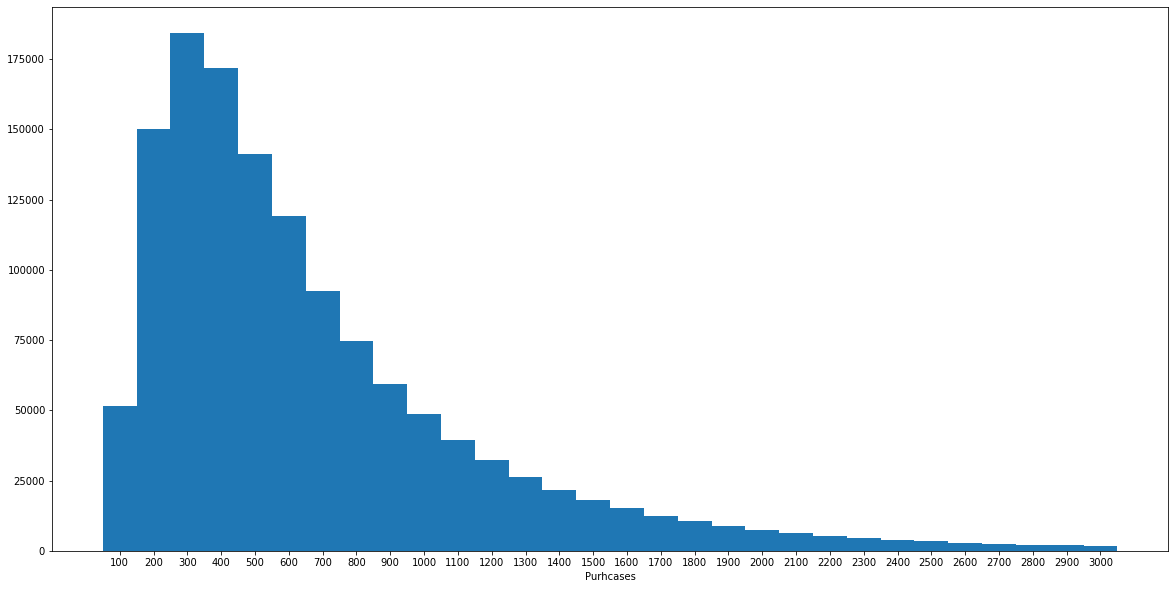

In [21]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(bins[1:])
ax.set_xlabel('Purhcases')
ax.set_ylabel('Amount of customers')
plt.bar(bins[1:], height, width=step)

# Amount of purchases

In [22]:
# Get only unique orders
df_agg = df.groupby(['id_card', 'id_doc'], as_index=False).first().groupby('id_card').agg({'id_doc':'count'})

In [23]:
values = df_agg['id_doc'].values

In [27]:
max_price = np.quantile(values, 0.99)
start, stop, step = 0, max_price, 1
# Take sums from boughts wich has discounts
height, bins = np.histogram(values, np.arange(start, stop, step))

<BarContainer object of 26 artists>

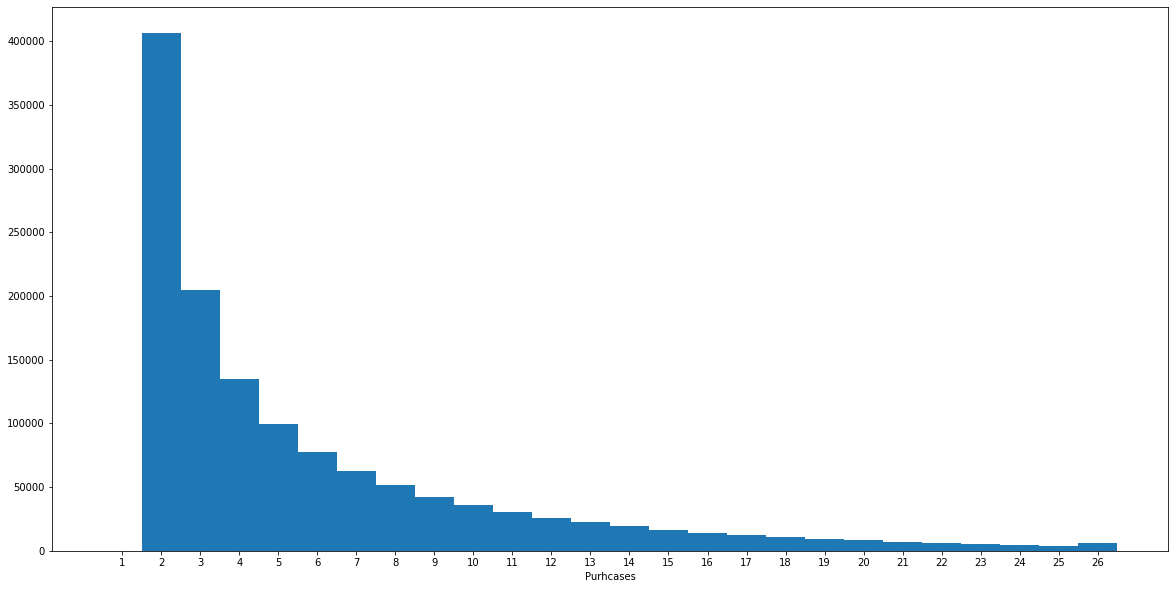

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(bins[1:])
ax.set_xlabel('Amount of purchases')
ax.set_ylabel('Amount of customer')
plt.bar(bins[1:], height, width=step)

# Amount of purchases

In [33]:
# Get only unique orders
df_agg = df.groupby(['id_card', 'id_group'], as_index=False).first().groupby('id_group').agg({'id_card':'count'})

In [44]:
# Drop group -9999
df_agg = df_agg.drop(-9999)

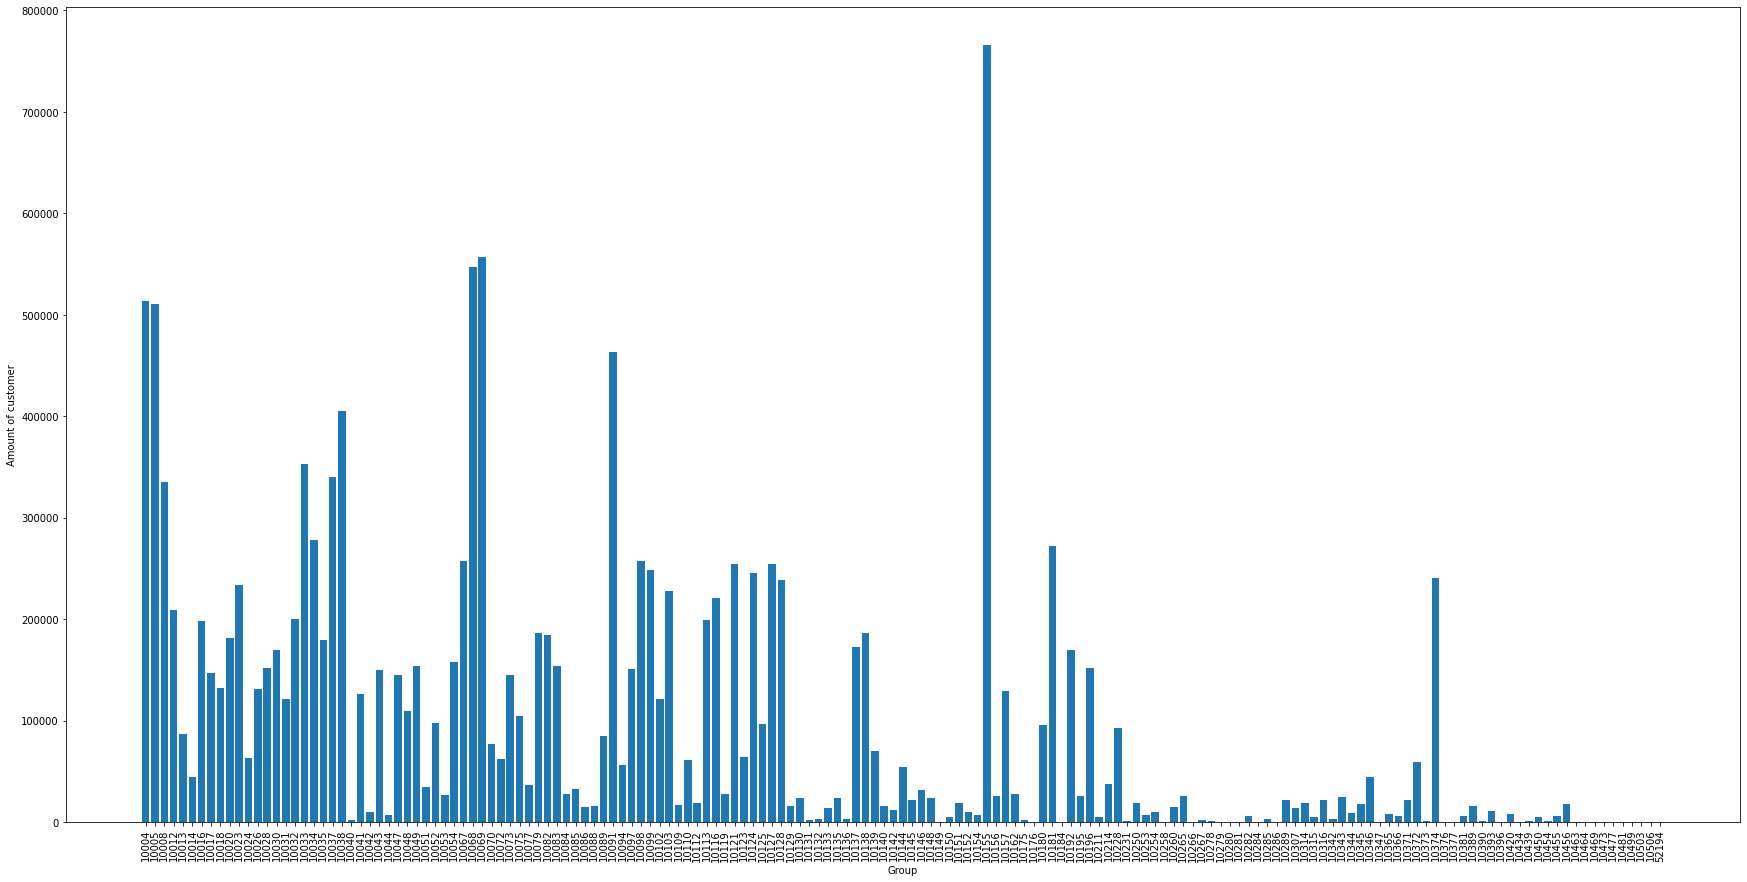

In [64]:
values = df_agg['id_card'].values
labels = df_agg.index.values

fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Group')
ax.set_ylabel('Amount of customer')
plt.bar([str(x) for x in labels], values)
_ = plt.xticks(rotation=90)